## Data cleaning

In [1]:
import pandas as pd
df = pd.read_csv('https://raw.githubusercontent.com/hflabs/city/master/city.csv')
df.head(5)

,address,postal_code,country,federal_district,region_type,region,area_type,area,city_type,city,...,fias_level,capital_marker,okato,oktmo,tax_office,timezone,geo_lat,geo_lon,population,foundation_year
0,"Респ Адыгея, г Адыгейск",385200.0,Россия,Южный,Респ,Адыгея,NaN,NaN,г,Адыгейск,...,4,0,79403000000,79703000001,107,UTC+3,44.878414,39.190289,12689,1969
1,г Майкоп,385000.0,Россия,Южный,Респ,Адыгея,NaN,NaN,г,Майкоп,...,4,2,79401000000,79701000001,105,UTC+3,44.609827,40.100661,144055,1857
2,г Горно-Алтайск,649000.0,Россия,Сибирский,Респ,Алтай,NaN,NaN,г,Горно-Алтайск,...,4,2,84401000000,84701000001,400,UTC+7,51.958103,85.960324,62861,1830
3,"Алтайский край, г Алейск",658125.0,Россия,Сибирский,край,Алтайский,NaN,NaN,г,Алейск,...,4,0,1403000000,1703000001,2201,UTC+7,52.492251,82.779361,28528,1913
4,г Барнаул,656000.0,Россия,Сибирский,край,Алтайский,NaN,NaN,г,Барнаул,...,4,2,1401000000,1701000001,2200,UTC+7,53.347997,83.779806,635585,1730


In [2]:
df = df[['city', 'geo_lat', 'geo_lon', 'population']]
df.head(5)

,city,geo_lat,geo_lon,population
0,Адыгейск,44.878414,39.190289,12689
1,Майкоп,44.609827,40.100661,144055
2,Горно-Алтайск,51.958103,85.960324,62861
3,Алейск,52.492251,82.779361,28528
4,Барнаул,53.347997,83.779806,635585


In [3]:
df = df.sort_values(by=['population'], ascending=False)
df.head(5)

,city,geo_lat,geo_lon,population
509,NaN,55.754047,37.620405,11514330
786,NaN,59.939131,30.315900,4848742
647,Новосибирск,55.028191,82.921149,1498921
832,Екатеринбург,56.838522,60.605491,1377738
619,Нижний Новгород,56.324063,44.005391,1250615


In [4]:
df.isnull().sum()

city          14
geo_lat        0
geo_lon        0
population     0
dtype: int64

In [5]:
df = df.dropna()
df.head(5)

,city,geo_lat,geo_lon,population
647,Новосибирск,55.028191,82.921149,1498921
832,Екатеринбург,56.838522,60.605491,1377738
619,Нижний Новгород,56.324063,44.005391,1250615
927,Казань,55.794358,49.111497,1216965
782,Самара,53.195031,50.106952,1164900


In [6]:
df.head(30).nunique()

city          30
geo_lat       30
geo_lon       30
population    30
dtype: int64

Luckily, top 30 populated cities are unique.

In [7]:
df = df.head(30).reset_index(drop=True)

In [8]:
!pip install utm
import utm
from scipy.spatial import distance 
from geopy import distance as gdistance

cities = df['city'].values

# Get distances between cities
locations = df[['geo_lat', 'geo_lon']].values
distances = distance.cdist(locations, locations, lambda a, b: gdistance.distance(a, b).km)

# Convert long, lat to x, y
xys = df.apply(lambda row: utm.from_latlon(row['geo_lat'], row['geo_lon'])[:2], axis=1).values
xs = [p[0] for p in xys]
ys = [p[1] for p in xys]

## Simulated Annealing

1. Initialize path, time t = 0, temperature = initial distance, min temperature = temperature/10000
1. Generate new path by swapping two random cities in current path
1. Calculate acceptance ratio and update path
1. Repeat 2-3 N times (default N = 100)
1. Reduce temperature using Exponential decay (default decay constant = 0.05)
1. Increment time
1. Repeat 2-6 until cool down

In [9]:
import random, math
def anneal(distances, decay=0.05, N = 100):
  # Helper functions
  def get_dist(path, distances):
    total = 0
    for i in range(len(path) - 1):
      total += distances[path[i]][path[i+1]]
    return total + distances[path[0]][path[-1]]

  def get_new_path(path):
    new_path = path.copy()
    idx1 = random.choice([i for i in range(len(new_path))])
    idx2 = random.choice([i for i in range(len(new_path)) if i != idx1])
    new_path[idx1], new_path[idx2] = new_path[idx2], new_path[idx1]
    return new_path
  def get_ratio(new_dist, dist, T):
    return math.exp(-new_dist/T) / math.exp(-dist/T)

  # Initialize path, temperatures, time, logs
  path = [i for i in range(len(distances))]
  dist = get_dist(path, distances)
  T_init = dist
  T_min = T_init / 1000
  T = T_init
  t = 0
  path_logs = [path]
  dist_logs = [dist]

  # Update path, cool down
  while (T > T_min):
    for _ in range(max(N, 1)):
      new_path = get_new_path(path)
      new_dist = get_dist(new_path, distances)
      ratio = get_ratio(new_dist, dist, T)
      u = random.uniform(0, 1)
      if (ratio > u):
        path = new_path
        dist = new_dist
    # Reduce temperature using Exponential decay
    t += 1
    T = T_init * math.exp(-decay*t)
    path_logs.append(path)
    dist_logs.append(dist)

  return path_logs, dist_logs

## Animation

In [10]:
from IPython.display import HTML
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter, FFMpegWriter

def animate_dists(dists):
  fig, ax = plt.subplots()
  xdata, ydata = [], []
  ln, = plt.plot([], [])

  def init():
      ax.set_ylim(0, int(dists[0])+1)
      ax.set_xlim(0, len(dists))
      return ln,

  def update(i):
      xdata.append(i)
      ydata.append(dists[i])
      ln.set_data(xdata, ydata)
      return ln,

  ani = FuncAnimation(fig, update, frames=len(dists),
                      init_func=init, blit=True)
  return ani

def animate_paths(paths):
  fig, ax = plt.subplots()
  ln, = plt.plot([], [], linestyle='-', marker='o')

  def init():
      ax.set_ylim(int(min(ys) - 50000), int(max(ys) + 50000))
      ax.set_xlim(int(min(xs) - 50000), int(max(xs) + 50000))
      return ln,

  def update(i):
      xdata = [xs[j] for j in paths[i]] + [xs[paths[i][0]]]
      ydata = [ys[j] for j in paths[i]] + [ys[paths[i][0]]]
      ln.set_data(xdata, ydata)
      return ln,

  ani = FuncAnimation(fig, update, frames=len(paths),
                      init_func=init, blit=True)
  return ani

## Applying Simulated Annealing and Animation

### Decay constant = 0.05

Speed of convergence: 332.199159425816
Final distance: 18373.30676515823


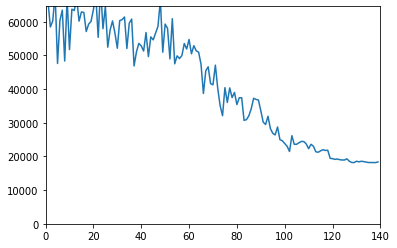

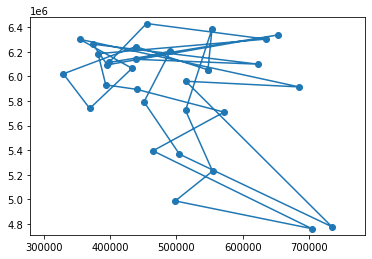

In [11]:
# Simulate annealing
paths, dists = anneal(distances, decay=0.05)
# Average speed of convergence
speed = (dists[0] - dists[-1]) / (len(dists) - 1)
print(f'Speed of convergence: {speed}')
print(f'Final distance: {dists[-1]}')
# Animate
dist_ani = animate_dists(dists)
path_ani = animate_paths(paths)
# Save animation
dist_ani.save('dist-avg.gif', writer='pillow', fps=30)
path_ani.save('path-avg.gif', writer='pillow', fps=30)

In [12]:
HTML(path_ani.to_html5_video())

### Decay constant = 0.5

Speed of convergence: 2833.279436317785
Final distance: 24883.077816897672


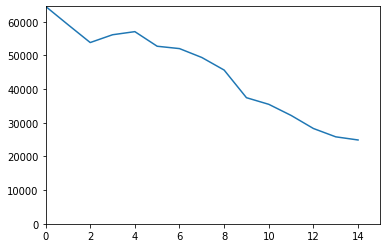

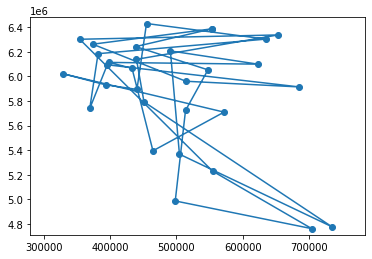

In [13]:
# Simulate annealing
paths, dists = anneal(distances, decay=0.5)
# Average speed of convergence
speed = (dists[0] - dists[-1]) / (len(dists) - 1)
print(f'Speed of convergence: {speed}')
print(f'Final distance: {dists[-1]}')
# Animate
dist_ani = animate_dists(dists)
path_ani = animate_paths(paths)
# Save animation
dist_ani.save('dist-fast.gif', writer='pillow', fps=30)
path_ani.save('path-fast.gif', writer='pillow', fps=30)

In [14]:
HTML(path_ani.to_html5_video())

### Decay constant = 0.005

Speed of convergence: 3.388926622844403
Final distance: 17727.579704128388


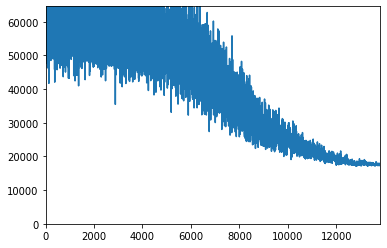

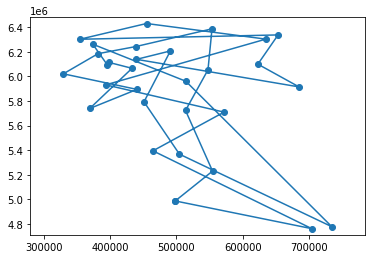

In [15]:
# Simulate annealing
paths, dists = anneal(distances, decay=0.0005)
# Average speed of convergence
speed = (dists[0] - dists[-1]) / (len(dists) - 1)
print(f'Speed of convergence: {speed}')
print(f'Final distance: {dists[-1]}')
# Animate
dist_ani = animate_dists(dists)
path_ani = animate_paths(paths)
# Save animation
dist_ani.save('dist-slow.gif', writer='pillow', fps=30)
path_ani.save('path-slow.gif', writer='pillow', fps=30)

In [16]:
HTML(path_ani.to_html5_video())

Animation movie is 95653003 bytes, exceeding the limit of 20971520.0. If you're sure you want a large animation embedded, set the animation.embed_limit rc parameter to a larger value (in MB).
